# Topic:        Challenge Set 7
# Subject:      Pandas Challenges
# Date:         02/13/2017
# Name:         Rosie Hoyem

In [145]:
%matplotlib inline

from __future__ import print_function
from statsmodels.compat import lzip
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import cross_val_score

## Topic: Classification

**Settings: Where applicable, use test_size=.30, random_state=4444. This will permit comparison of results across users.

Data:

Challenges 1-10: congressional votes Congressional Voting Records Dataset

Challenge 11: movie data

Challenge 12: breast cancer surgery Haberman Survival Dataset

Data – Congressional Votes

Download the congressional votes data from here:Congressional Voting Records Dataset

These are votes of U.S. House of Representatives Congressmen on 16 key issues in 1984.

Read the description of the fields and download the data: house-votes-84.data

We will try to see if we can predict the house members' party based on their votes.

We will also use some of the general machine learning tools we learned (a bit more efficiently this time).

**Challenge 1**

Load the data into a pandas dataframe. Replace 'y's with 1s, 'n's with 0s.

Now, almost every representative has a ?. This represents the absence of a vote (they were absent or some other similar reason). If we dropped all the rows that had a ?, we would throw out most of our data. Instead, we will replace ? with the best guess in the Bayesian sense: in the absence of any other information, we will say that the probability of the representative saying YES is the ratio of others that said YES over the whole votes.

So, convert each ? to this probability (when yes=1 and no=0, this is the mean of the column)

In [93]:
column_names = ['party', 'handicapped_infants','water_project_cost_sharing',\
  'adoption_of_the_budget_resolution','physician_fee_freeze','el_salvador_aid', 'religious_groups_in_schools',\
  'anti_satellite_test_ban','aid_to_nicaraguan_contras','mx_missile', 'immigration', 'synfuels_corporation_cutback',\
  'education_spending','superfund_right_to_sue','crime','duty_free_exports','export_administration_act_south_africa']

In [99]:
raw_df = pd.read_csv('data/house-votes-84.csv', names=column_names)
print(raw_df.shape)
raw_df.head()

(435, 17)


,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [100]:
def make_binary(df, cols):
    convert = lambda x : 1 if x == 'y' else 0
    for col in cols:
        df[col] = df[col].apply(convert) 
    return df

def convert_party(df,col):
    convert = lambda x : 1 if x == 'democrat' else 0
    df[col] = df[col].apply(convert) 
    return df

def convert_quest(df, cols):
    for col in cols:
        yeses = len(df[df[col] == 'y'])
        nos = len(df[df[col] == 'n'])
        value = 'y' if yeses > nos else 'n'
        df[col] = df[col].replace('?', value)
    return df

def cast_as_int(df, cols):
    for col in cols:
        df[col] = df[col].astype(int, copy=False)
    return df

In [101]:
cols = raw_df.ix[:,1:].columns

df = convert_quest(raw_df, cols)
df = make_binary(df, cols)
df = convert_party(df, 'party')
df = cast_as_int(df, df.columns)

df.head()

,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1
1,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
2,1,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0
3,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1
4,1,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
party                                     435 non-null int64
handicapped_infants                       435 non-null int64
water_project_cost_sharing                435 non-null int64
adoption_of_the_budget_resolution         435 non-null int64
physician_fee_freeze                      435 non-null int64
el_salvador_aid                           435 non-null int64
religious_groups_in_schools               435 non-null int64
anti_satellite_test_ban                   435 non-null int64
aid_to_nicaraguan_contras                 435 non-null int64
mx_missile                                435 non-null int64
immigration                               435 non-null int64
synfuels_corporation_cutback              435 non-null int64
education_spending                        435 non-null int64
superfund_right_to_sue                    435 non-null int64
crime                                    

In [241]:
import pickle

with open('data/political_vote_data.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

**Challenge 2**

Split the data into a test and training set. Use this function:

`from sklearn.cross_validation import train_test_split`

In [102]:
from sklearn.cross_validation import train_test_split

X = df.ix[:,1:]
y = df['party']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4444)

**Challenge 3**

Using scikit.learn's KNN algorithm, train a model that predicts the party (republican/democrat):

`from sklearn.neighbors import KNeighborsClassifier`

Try it with a lot of different k values (number of neighbors), from 1 to 20, and on the test set calculate the accuracy (number of correct predictions / number of all predictions) for each k

You can use this to calculate accuracy:

`from sklearn.metrics import accuracy_score`

Which k value gives the highest accuracy?

In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_accs = []
for k in range (1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    k_accs.append(acc)
    print("KNN " + str(k) + ": " + str(acc))


KNN 1: 0.916030534351
KNN 2: 0.893129770992
KNN 3: 0.916030534351
KNN 4: 0.923664122137
KNN 5: 0.916030534351
KNN 6: 0.916030534351
KNN 7: 0.916030534351
KNN 8: 0.923664122137
KNN 9: 0.908396946565
KNN 10: 0.916030534351
KNN 11: 0.923664122137
KNN 12: 0.923664122137
KNN 13: 0.923664122137
KNN 14: 0.916030534351
KNN 15: 0.923664122137
KNN 16: 0.916030534351
KNN 17: 0.908396946565
KNN 18: 0.908396946565
KNN 19: 0.908396946565
KNN 20: 0.900763358779


**Challenge 4**

Make a similar model but with LogisticRegression instead, calculate test accuracy.

In [134]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logit: " + str(accuracy_score(y_test, y_pred)))

Logit: 0.93893129771


**Challenge 5**

Make a bar graph of democrats and republicans. How many of each are there?

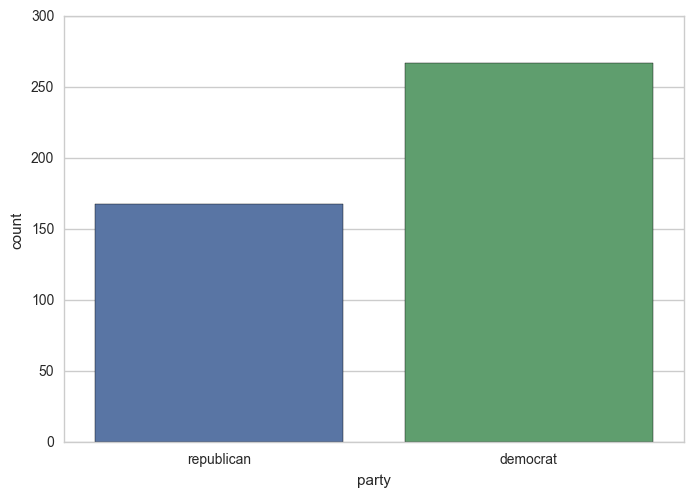

In [86]:
sns.set_style("whitegrid")
ax = sns.countplot(x=df['party'], data=df)

Make a very simple predictor that predicts 'democrat' for every incoming example.

Just make a function that takes in an X --an array or matrix with input examples--, and returns an array of the same length as X, where each value is 'democrat'. For example, if X is three rows, your function should return ['democrat','democrat','democrat']. Make a y_predicted vector using this and measure its accuracy.

Do the same with predicting 'republican' all the time and measure its accuracy.

In [112]:
def predict_dem(series):
    pred = []
    for i in series:
        pred.append(1)
    return pred
        
predict_dem([1,0,1,1])

[1, 1, 1, 1]

In [139]:
x = predict_dem(y_test)

print("KNN: " + str(accuracy_score(y_test, x)))
print(y_test.mean())

KNN: 0.587786259542
0.587786259542


In [114]:
def predict_rep(series):
    pred = []
    for i in series:
        pred.append(0)
    return pred
        
predict_rep([1,0,1,1])

[0, 0, 0, 0]

**Challenge 6**

Plot the accuracies as a function of k. Since k only matters for KNN, your logistic regression accuracy, 'democrat' predictor accuracy and 'republican' predictor accuracy will stay the same over all k, so each of these three will be a horizontal line. But the KNN accuracy will change with k.

In [127]:
k_range = list(range(1,21))

print(k_range)
print(k_accs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.91603053435114501, 0.89312977099236646, 0.91603053435114501, 0.92366412213740456, 0.91603053435114501, 0.91603053435114501, 0.91603053435114501, 0.92366412213740456, 0.90839694656488545, 0.91603053435114501, 0.92366412213740456, 0.92366412213740456, 0.92366412213740456, 0.91603053435114501, 0.92366412213740456, 0.91603053435114501, 0.90839694656488545, 0.90839694656488545, 0.90839694656488545, 0.9007633587786259]


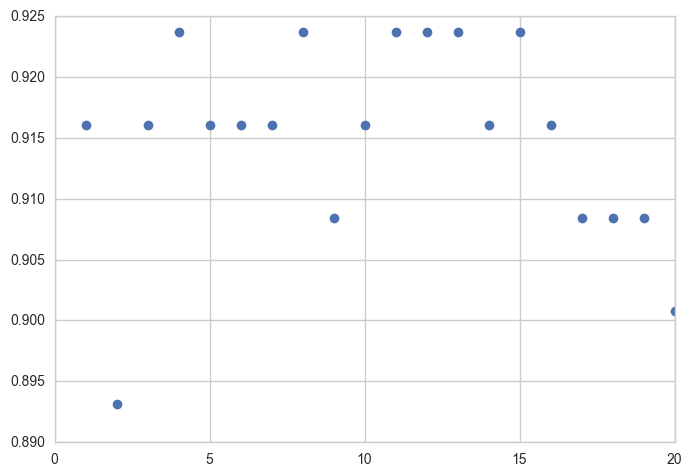

In [131]:
plt.plot(k_range, k_accs, 'o')
plt.xlabel = "K"
plt.ylabel = "KNN Accuracy"

**Challenge 7**

Plot a learning curve for the logistic regression model. But instead of going through the painstaking steps of doing it yourself, use this function:

`from sklearn.learning_curve import learning_curve`

This will give you the m, training errors and testing errors. All you need to do is plot them. You don't even need to give it separate training/test sets. It will do crossvalidation all by itself. Easy, isn't it? : ) Remember, since it does cross-validation, it doesn't have a single training error or test error per m value. Instead, it has one for each fold (separate partition) of the cross validation. A good idea is to take the mean of these errors from different folds. This gives you a meaningful single number per m. What I mean is that doing something like:

`train_cv_err = np.mean(train_err, axis=1)`

`test_cv_err = np.mean(ts_err, axis=1)`

In [140]:
from sklearn.learning_curve import learning_curve

In [141]:
#plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(), X, y, train_sizes=[50, 80, 110], cv=5)

Before plotting m vs train_cv_err and m vs test_cv_err, where train_err and test_err are the vectors returned by the learning curve function. The np.mean(...., axis=1) means take the mean along axis 1 (axis 1 is the columns axis-- for each row, you have a bunch of columns, each corresponding to a cross validation fold, you are averaging these columns for each row).

Draw the learning curve for KNN with the best k value as well.

**Challenge 8**

This is a preview of many other classification algorithms that we will go over. Scikit.learn has the same interface for all of these, so you can use them exactly the same way as you did LogisticRegression and KNeighborsClassifier. Use each of these to classify your data and print the test accuracy of each:

Gaussian Naive Bayes

```
from sklearn.naive_bayes import GaussianNB
```

SVM (Support Vector Machine) Classifier

`from sklearn.svm import SVC`

Decision Tree

`from sklearn.tree import DecisionTreeClassifier`

Random Forest

`from sklearn.ensemble import RandomForestClassifier`

In [147]:
from sklearn.naive_bayes import GaussianNB

gaus = GaussianNB()
gaus.fit(X_train, y_train)
y_pred = gaus.predict(X_test)
print("GaussianNB: " + str(accuracy_score(y_test, y_pred)))

GaussianNB: 0.93893129771


In [149]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("SVC: " + str(accuracy_score(y_test, y_pred)))

SVC: 0.954198473282


In [150]:
from sklearn.tree import DecisionTreeClassifier

dectree = DecisionTreeClassifier()
dectree.fit(X_train, y_train)
y_pred = dectree.predict(X_test)
print("DecisionTreeClassifier: " + str(accuracy_score(y_test, y_pred)))

DecisionTreeClassifier: 0.923664122137


In [151]:
from sklearn.ensemble import RandomForestClassifier

randforest = RandomForestClassifier()
randforest.fit(X_train, y_train)
y_pred = randforest.predict(X_test)
print("RandomForestClassifier: " + str(accuracy_score(y_test, y_pred)))

RandomForestClassifier: 0.931297709924


**Challenge 9**

There is actually a way to do cross validation quickly to get your accuracy results for an algorithm, without separating training and test yourself:

```
from sklearn.cross_validation import cross_val_score
```

Just like the learning_curve function, this takes a classifier object, X and Y. Returns accuracy (or whatever score you prefer by using the scoring keyword argument). Of course, it will return a score for each cross validation fold, so to get the generalized accuracy, you need to take the mean of what it returns.

Use this function to calculate the cross validation score of each of the classifiers you tried before.

In [152]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[ 0.97727273  0.90909091  0.95454545  0.86363636  0.97727273  0.90909091
  0.97727273  0.95348837  0.80952381  0.9047619 ]


In [153]:
scores = cross_val_score(gaus, X, y, cv=10, scoring='accuracy')
print(scores)

[ 0.95454545  0.93181818  0.97727273  0.81818182  0.97727273  0.90909091
  0.97727273  0.97674419  0.76190476  0.95238095]


In [154]:
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)

[ 0.97727273  0.95454545  0.97727273  0.95454545  1.          0.90909091
  1.          0.97674419  0.83333333  0.97619048]


In [155]:
scores = cross_val_score(dectree, X, y, cv=10, scoring='accuracy')
print(scores)

[ 0.97727273  0.97727273  1.          0.90909091  0.97727273  0.93181818
  0.97727273  0.90697674  0.85714286  0.97619048]


In [163]:
scores = cross_val_score(randforest, X, y, cv=10, scoring='accuracy')
print(scores)
print("Mean: " + np.mean(scores)

[ 0.97727273  0.97727273  0.95454545  0.97727273  0.97727273  0.90909091
  1.          0.93023256  0.88095238  0.97619048]


TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

**Challenge 10**

Instead of 'democrat' or 'republican', can you predict the vote of a representative based on their other votes?

Reload the data from scratch. Convert y-->1, n-->0.

Choose one vote. Build a classifier (logistic regression or KNN), that uses the other votes (do not use the party as a feature) to predict if the vote will be 1 or 0.

Convert each ? to the mode of the column (if a senator has not voted, make their vote 1 if most others voted 1, make it 0 if most others voted 0).

Calculate the cross validation accuracy of your classifier for predicting how each representative will vote on the issue.

In [143]:
X10 = df.ix[:,1:15]
y10 = df["export_administration_act_south_africa"]

X10_train, X10_test, y10_train, y10_test = train_test_split(X, y, test_size=0.3, random_state=4444)

In [146]:
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X10, y10, cv=10, scoring='accuracy')
print(scores)

[ 0.82222222  0.86666667  0.81818182  0.8372093   0.81395349  0.86046512
  0.86046512  0.90697674  0.81395349  0.86046512]


**Challenge 11**

Back to movie data! Choose one categoric feature to predict. I chose MPAA Rating, but genre, month, etc. are all decent choices. If you don't have any non-numeric features, you can make two bins out of a numeric one (like "Runtime>100 mins" and "Runtime<=100 mins")

In [198]:
movie_df = pd.read_csv('data/2013_movies.csv')
print(movie_df.shape)
movie_df.head()

(100, 7)


,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
0,The Hunger Games: Catching Fire,130000000.0,424668047,Francis Lawrence,PG-13,146,2013-11-22 00:00:00
1,Iron Man 3,200000000.0,409013994,Shane Black,PG-13,129,2013-05-03 00:00:00
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22 00:00:00
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03 00:00:00
4,Man of Steel,225000000.0,291045518,Zack Snyder,PG-13,143,2013-06-14 00:00:00


Make a bar graph of how many of each movie there is in the data. For example, with Ratings, show how many G, PG, PG-13, R movies there are, etc. (basically a histogram of your labels).

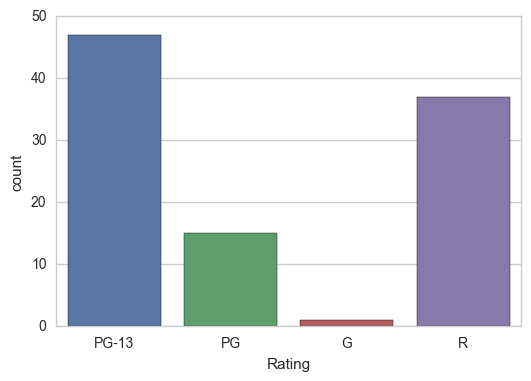

In [204]:
movie_df['Rating'].value_counts()
sns.set_style("whitegrid")
ax = sns.countplot(x=movie_df['Rating'], data=movie_df)

Predict your outcome variable (labels) using KNN and logistic regression. Calculate their accuracies.

In [209]:
movie_df = movie_df.dropna()
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 99
Data columns (total 7 columns):
Title                 87 non-null object
Budget                87 non-null float64
DomesticTotalGross    87 non-null int64
Director              87 non-null object
Rating                87 non-null object
Runtime               87 non-null int64
ReleaseDate           87 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 5.4+ KB


In [215]:
from sklearn import preprocessing

X11 = movie_df[['Budget', 'DomesticTotalGross', 'Runtime']]
y11 = movie_df['Rating']

# This issue appears to be here
X11_scaled = preprocessing.scale(X11)

X11_train, X11_test, y11_train, y11_test = train_test_split(X11_scaled, y11, test_size=0.3, random_state=4444)

In [231]:
knn11 = KNeighborsClassifier(n_neighbors=5)
knn11.fit(X11_train, y11_train)
y11_pred = knn11.predict(X11_test)
acc = accuracy_score(y11_test, y11_pred)
print("KNN Accuracy: " + str(acc))

KNN Accuracy: 0.481481481481


In [235]:
logit11 = LogisticRegression()
logit11_results = logit11.fit(X11_train, y11_train)
y11_pred = logit11.predict(X11_test)
acc = accuracy_score(y11_test, y11_pred)
print("LogisticRegression Accuracy: " + str(acc))

LogisticRegression Accuracy: 0.481481481481


Make a baseline stupid predictor that always predicts the label that is present the most in the data. Calculate its accuracy on a test set.

In [230]:
def predict_pg13(series):
    pred = []
    for i in series:
        pred.append('PG-13')
    return pred

y11_pg13pred = predict_pg13(y11_test)

print("Baseline Accuracy: " + str(accuracy_score(y11_test, y11_pg13pred)))

Baseline Accuracy: 0.407407407407


How much better do KNN and logistic regression do versus the baseline?

- Baseline Accuracy: 0.407407407407
- KNN Accuracy: 0.481481481481
- LogisticRegression Accuracy: 0.481481481481

What are the coefficients of logistic regression? Which features affect the outcome how?

In [240]:
sigmoid( dot([val1, val2, 2], logit11.coef_.T) )

NameError: name 'sigmoid' is not defined

**Challenge 12**

Now you are a classification master. The representative votes dataset only had 0s and 1s. Let's just swiftly tackle the breast cancer surgery data.

Get it from here: Haberman Survival Dataset

Attribute Information:
   1. Age of patient at time of operation (numerical)
   2. Patient's year of operation (year - 1900, numerical)
   3. Number of positive axillary nodes detected (numerical)
   4. Survival status (class attribute)
         1 = the patient survived 5 years or longer
         2 = the patient died within 5 year

In [162]:
column_names = ['age', 'year_of_op','nodes','survival_status']
cancer_df = pd.read_csv('data/haberman.data.csv', names=column_names)
print(cancer_df.shape)
cancer_df.head()

(306, 4)


,age,year_of_op,nodes,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [166]:
for col in cancer_df.columns:
    cancer_df[col] = cancer_df[col].astype(int, copy=False)
    
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
age                306 non-null int64
year_of_op         306 non-null int64
nodes              306 non-null int64
survival_status    306 non-null int64
dtypes: int64(4)
memory usage: 9.6 KB


- What is the average and standard deviation of the age of all of the patients?

In [172]:
print("Average Age: " + str(cancer_df['age'].mean()))
print("Standard Deviation of Age: " + str(cancer_df['age'].std()))

Average Age: 52.4575163399
Standard Deviation of Age: 10.8034523493


- What is the average and standard deviation of the age of those patients that survived 5 or more years after surgery?

In [173]:
surv_5year = cancer_df[cancer_df['survival_status']==1]
print("Average Age: " + str(surv_5year['age'].mean()))
print("Standard Deviation of Age: " + str(surv_5year['age'].std()))

Average Age: 52.0177777778
Standard Deviation of Age: 11.0121541799


- What is the average and standard deviation of the age of those patients who survived fewer than 5 years after surgery?

In [175]:
surv_less5year = cancer_df[cancer_df['survival_status']==2]
print("Average Age: " + str(surv_less5year['age'].mean()))
print("Standard Deviation of Age: " + str(surv_less5year['age'].std()))

Average Age: 53.6790123457
Standard Deviation of Age: 10.1671372083


- Plot a histogram of the ages side by side with a histogram of the number of axillary nodes.

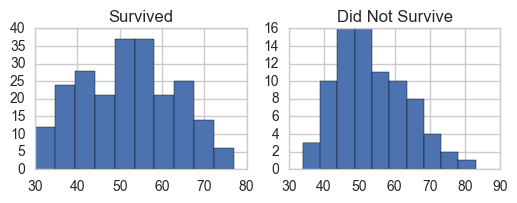

In [184]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax1.hist(surv_5year['age'])
ax1.set_title('Survived')
ax2.hist(surv_less5year['age'])
ax2.set_title('Did Not Survive');

- What is the earliest year of surgery in this dataset?

In [186]:
print("Earlier year of surgery: " + str(cancer_df['age'].min()))

Earlier year of surgery: 30


- What is the most recent year of surgery?

In [187]:
print("Most recent year of surgery: " + str(cancer_df['age'].max()))

Most recent year of surgery: 83


- Use logistic regression to predict survival after 5 years. How well does your model do?

In [194]:
X12 = cancer_df[['age', 'year_of_op','nodes']]
y12 = cancer_df['survival_status']

X12_train, X12_test, y12_train, y12_test = train_test_split(X12, y12, test_size=0.3, random_state=4444)

logit12 = LogisticRegression()
results12 = logit12.fit(X12_train, y12_train)
y12_pred = logit12.predict(X12_test)
print("Logit: " + str(accuracy_score(y12_test, y12_pred)))

Logit: 0.815217391304


- What are the coefficients of logistic regression? Which features affect the outcome how?

In [195]:
results12.summary()

AttributeError: 'LogisticRegression' object has no attribute 'summary'

- Draw the learning curve for logistic regression in this case.